# Duel network architecture for DRL with prioritized experience replay

## Delete all the memory consuming objects

In [90]:
# %reset

## Setup

In [91]:
## Setup

import gym

import numpy as np
import matplotlib.pyplot as plt

import random
import os
from datetime import datetime, timedelta
import time
import pickle

import imageio

import tensorflow as tf
print(tf.__version__)
# tf.image module contains image processing functions
# from tensorflow.image import rgb_to_grayscale, resize
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Lambda, Add
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber

# email
import smtplib
import ssl
from email.mime.text import MIMEText
from email.mime.image import MIMEImage
from email.mime.multipart import MIMEMultipart

2.1.0


## GPU

In [92]:
print(tf.__version__)
print(tf.test.gpu_device_name())
# print(tf.config.list_physical_devices('GPU'))
# print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2.1.0
/device:GPU:0


## Hyperparameter

In [93]:
## Hyperparameter

### change
# NUM_EPISODES = 1000000
NUM_EPISODES = 5000
# NUM_EPISODES = 100
# NUM_EPISODES = 4
# NUM_EPISODES = 2

# DELAY_TRAINING = 50000
DELAY_TRAINING = 500
# DELAY_TRAINING = 10

MODEL_SAVE_FREQ = 500
# MODEL_SAVE_FREQ = 10
# MODEL_SAVE_FREQ = 2

GIF_RECORDING_FREQ = 500
# GIF_RECORDING_FREQ = 100
# GIF_RECORDING_FREQ = 10
# GIF_RECORDING_FREQ = 2

EMAIL_MONITORING = 250
# EMAIL_MONITORING = 2

MEMORY_SIZE = 100000

# STORE_PATH = '/content'
STORE_PATH = '/home/ubuntu/rl'

REWARD_PATH = '/home/ubuntu/rl/duel_total_rewards.pkl'

# speed of video (the smaller, the faster)
FPS = 30


###
ENV = 'SpaceInvaders-v0'

### prioritized experience replay proportional variant sweet spot values
# alpha and beta are from (Schaul et al., 2016) 4 ATARI EXPERIMENTS
ALPHA = 0.6
# beta value is at the beginning of training, and annealed towards 1 at the end of training
BETA = 0.4
MIN_PRIORITY = 0.01

# (resized height, resized width, gray scale)
POST_PROCESS_IMAGE_SIZE = (105, 80, 1)
# original image sizes from the Atari Space Invaders
PRIOR_H = 210
PRIOR_W = 160
# color channel
PRIOR_C = 3
POST_H = 105
POST_W = 80
POST_C = 1
# stacking frames
# NUM_FRAMES = 3
NUM_FRAMES = 4

# get number of actions from action_space.n attribute of env object instead
# NUM_ACTIONS = 6

# network update from Double Q learning?
# TAU = 0.05
TAU = 0.08
# gif
PATH_GIF = ""
FILE = "si.gif"
GAMMA = 0.99
BATCH_SIZE = 32

MAX_EPSILON = 1
MIN_EPSILON = 0.1
EPSILON_MIN_ITER = 500000

MIN_BETA = 0.4
MAX_BETA = 1.0
BETA_DECAY_ITERS = 500000

# email
PORT_EMAIL = 465
PASSWORD_EMAIL = 'test123TEST!'
SENDER_EMAIL = 'airflowkitayama@gmail.com'
RECEIVER_EMAIL = 'airflowkitayama@gmail.com'

plt.style.use('default')

## Monitoring email

In [94]:
def email_monitoring(episode, reward, avg_loss, epsilon, count, time):
    # make contents
    subject = 'DL instance RL monitoring during training'
    html = """
    <html>
      <p>episode:{:,.0f}, reward:{:,.0f}, avg loss:{:.5f} epsilon:{:.3f}, count:{:,.0f}, time:{:,.1f} from DL instance.</p>
    </html>
    """.format(episode, reward, avg_loss, epsilon, count, time)
    
    # make message
    msg = MIMEMultipart()
    msg['Subject'] = subject
    msg['From'] = SENDER_EMAIL
    msg['To'] = RECEIVER_EMAIL

    # attach content
    msgText = MIMEText(html, 'html')
    msg.attach(msgText)

    # send email
    context = ssl.create_default_context()
    with smtplib.SMTP_SSL('smtp.gmail.com', PORT_EMAIL, context = context) as server:
        server.login(SENDER_EMAIL, PASSWORD_EMAIL)
        server.sendmail(SENDER_EMAIL, RECEIVER_EMAIL, msg.as_string())

## Environment

number of actions 6
meaning of action space ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']
observation space Box(210, 160, 3)


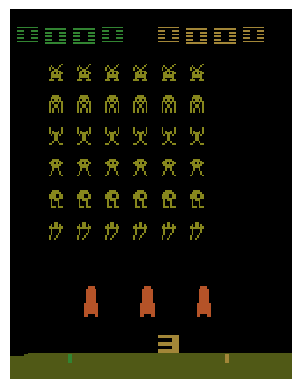

In [95]:
## Environment

env = gym.make(ENV)
num_actions = env.action_space.n
env.reset()


# show spec
# Discrete(6) but action index includes 0, 1, 2, 3, 4, 5
# print("action space", env.action_space)
print('number of actions', num_actions)
print("meaning of action space", env.get_action_meanings())
print("observation space", env.observation_space)

# show environment
plt.imshow(env.render('rgb_array'))
plt.axis('off')
plt.show()

## Sum tree data structure

In [96]:
## sum-tree data structure

# Node class defines information about each node in the tree
class Node:
    # each of these properties will point to another Node instance
    def __init__(self, left, right, is_leaf: bool = False, idx = None):
        self.left = left
        self.right = right
        self.is_leaf = is_leaf

        # the value property is initialized to be the sum of child left and right nodes
        # if not self.is_leaf:
        #     self.value = self.left.value + self.right.value
        self.value = sum(n.value for n in (left, right) if n is not None)

        self.parent = None
        self.idx = idx  # this value is only set for leaf nodes
        if left is not None:
            left.parent = self
        if right is not None:
            right.parent = self

    # cls is the first argument to class methods
    # https://www.python.org/dev/peps/pep-0008/#function-and-method-arguments
    @classmethod
    def create_leaf(cls, value, idx):
        # leaf variable is an instance of Node class
        leaf = cls(None, None, is_leaf = True, idx = idx)
        # leaf weight is set to the passed value
        leaf.value = value
        return leaf

def create_tree(input: list):
    """
    output:
        nodes[0] is the top-parent node
        leaf_node is the list of leaf nodes
    """
    nodes = [Node.create_leaf(v, i) for i, v in enumerate(input)]
    leaf_nodes = nodes
    while len(nodes) > 1:
        # each time the iterator is called, the element is removed from the iterator
        inodes = iter(nodes)
        # * used as a parameter to send a non-keyworded variable-length argument list to function
        nodes = [Node(*pair) for pair in zip(inodes, inodes)]
    return nodes[0], leaf_nodes

def retrieve(value: float, node: Node):
    """
    input:
        value is a uniformly sampled random value
        node is the top-parent node
    output:
        value of leaf node
    """
    # check if node is lead node
    # if true, the sum tree traversal has been completed
    if node.is_leaf:
        return node
    if node.left.value >= value:
        return retrieve(value, node.left)
    else:
        return retrieve(value - node.left.value, node.right)

def update(node: Node, new_value: float):
    change = new_value - node.value
    node.value = new_value
    propagate_changes(change, node.parent)

def propagate_changes(change: float, node: Node):
    node.value += change
    if node.parent is not None:
        propagate_changes(change, node.parent)

## Prioritized experience replay

In [97]:
## prioritized experience replay

class Memory:
    def __init__(self, size: int):
        self.size = size
        self.curr_insert_idx = 0
        self.available_samples = 0 # ?
        
        # what does buffer store? (state, action, reward, terminal)?
        # initialize everything in buffer as zero to make sure the size will be able to be maintained during training
        # it allows us to check whether it will crash during training because buffer uses memory size
        self.buffer = [(np.zeros((POST_H, POST_W), dtype = np.float), 0.0, 0.0, 0.0) for _ in range(self.size)]
        
        # prioritization parameter in stochastic prioritization
        # alpha determines how much prioritization is used, alpha = 0 is uniform
        # alpha scales prioritisation based o TD error
        # alpha = 0 is uniform ignoring TD error
        # alpha = 1 is sampling proportional to TD error
        self.alpha = ALPHA
        # beta is importance sampling parameter in annealing the bias
        # we want to minimise expected value of TD error, but prioritized samping skews or biases the expected value
        # importance sampling corrects the bias
        self.beta = BETA
        # min_priority ensures samples with low TD error still have a small chance of being selected for sampling
        self.min_priority = MIN_PRIORITY # add to each experience tuple
        
        # sum tree algorithm
        # sum tree is initialized with the number of leaf nodes equal to the size of the buffer with values 0
        self.base_node, self.leaf_nodes = create_tree([0 for i in range(self.size)])
        
        # location index in experience replay buffer
        self.frame_idx = 0
        self.action_idx = 1
        self.reward_idx = 2
        self.terminal_idx = 3

    def append(self, experience: tuple, priority: float):
        """
        Parameters
        ----------
        experiece : turple
        priority : float
        """
        self.buffer[self.curr_insert_idx] = experience
        self.update(self.curr_insert_idx, priority)
        self.curr_insert_idx += 1
        # reset current index if bigger than size
        if self.curr_insert_idx >= self.size:
            self.curr_insert_idx = 0
        # max out available samples at the memory buffer size?
        if self.available_samples + 1 < self.size:
            self.available_samples += 1
        else:
            self.available_samples = self.size - 1

    # calls the sum tree update function
    def update(self, idx: int, priority: float):
        """
        Parameters
        idx : int
        priority : float

        below update function is update function of sum tree algorithm helper function
        """
        update(self.leaf_nodes[idx], self.adjust_priority(priority))

    # stochastic prioritization (Schaul et al., 2016)
    def adjust_priority(self, priority: float):
        """
        Parameters
        priority : float

        Returns
        P_(i) = (priority + min_priority)^alphas
        """
        return np.power(priority + self.min_priority, self.alpha)

    def sample(self, num_samples: int):
        """
        Perform priority sampling of the experience buffer, 
        and calculate the importance sampling weights used in training 

        Parameters
        num_samples : int

        Returns
        states
        actions
        rewards
        next_states
        terminal
        sampled_idx : list of indices in experience replay buffer by prioritization
        is_weights : importance-sampling weights to anneal the bias from prioritization
        """
        sampled_idxs = []
        # importance-sampling weights (Schaul et al., 2016)
        is_weights = []
        sample_no = 0

        while sample_no < num_samples:
            # draw samples from uniform distribution including lower and excluding upper bound
            sample_val = np.random.uniform(0, self.base_node.value)
            # use tree sum retrieve function to get weight
            samp_node = retrieve(sample_val, self.base_node)

            # ?
            if NUM_FRAMES - 1 < samp_node.idx < self.available_samples - 1:
                sampled_idxs.append(samp_node.idx)
                # probability of sampling transition in stochastic prioritization (Schaul et al., 2016)
                # base_node.value is sum of all weights because of sum tree
                p = samp_node.value / self.base_node.value
                # inverse of (1/N) * (1/P(i)) because it powers -beta later
                is_weights.append((self.available_samples + 1) * p)
                sample_no += 1

        # annealing the bias
        is_weights = np.array(is_weights)
        # power -beta because it did N*P(i) earlier
        is_weights = np.power(is_weights, -self.beta)
        # normalizing weight only scales the update downwards?
        is_weights = is_weights / np.max(is_weights)

        # load state and next state according to sampled idxs
        # initialize
        states = np.zeros((num_samples, POST_H, POST_W, NUM_FRAMES), dtype = np.float32)
        next_states = np.zeros((num_samples, POST_H, POST_W, NUM_FRAMES), dtype = np.float32)
        actions = []
        rewards = []
        terminal = []

        for i, idx in enumerate(sampled_idxs):

            for j in range(NUM_FRAMES):
                # idx + j - NUM_FRAMES + 1(or 2) controls getting stacked images by index drawn from prioritization
                states[i, :, :, j] = self.buffer[idx + j - NUM_FRAMES + 1][self.frame_idx][:, :, 0] # 0 at last?
                next_states[i, :, :, j] = self.buffer[idx + j - NUM_FRAMES + 2][self.frame_idx][:, :, 0]
            actions.append(self.buffer[idx][self.action_idx])
            rewards.append(self.buffer[idx][self.reward_idx])
            terminal.append(self.buffer[idx][self.terminal_idx])

        return states, np.array(actions), np.array(rewards), next_states, np.array(terminal), sampled_idxs, is_weights

In [98]:
## test sample method of Memory class

# sampled_idx = [1, 5, 9]
# num_frames = 3

# for i, idx in enumerate(sampled_idx):
#     for j in range(num_frames):
#         state_buffer_idx = idx + j - num_frames + 1
#         next_state_buffer_idx = idx + j - num_frames + 2
#         print('i', i, 'idx', idx, 'j', j, 'state_buffer_idx', state_buffer_idx, 'next_state_buffer_idx', next_state_buffer_idx)

In [99]:
## test prioritized experience replay

# 100,000 uses about 7GB of RAM
# 1,000,000 will crash
# so use 100,000 buffer size

# tmp = Memory(100000)
# print(len(tmp.buffer))
# print(type(tmp.buffer[0]))
# print(tmp.buffer[0][0].shape)
# print(tmp.buffer[0][1:])

## Dueling network architecture

In [100]:
## Dueling network architecture

### the advantage function expresses the relative benefits of the various actions possible in state s

### aggregation layer
### the advantage function value is normalized with respect to the mean of the advantage function values over all actions in state s

class Network(tf.keras.Model):
    def __init__(self, hidden_size: int, num_actions: int, dueling: bool):
        super(Network, self).__init__()
        self.dueling = dueling
        self.conv1 = Conv2D(filters=16, kernel_size=(8, 8), strides=(4, 4), activation='relu')
        self.conv2 = Conv2D(filters=32, kernel_size=(4, 4), strides=(2, 2), activation='relu')
        self.flatten = Flatten()
        # advantage function A(s, a)
        # kernel_initializer?
        # he_normal draws samples from a truncated normal distribution centered on 0 with some std
        self.adv_dense = Dense(units=hidden_size, activation='relu', kernel_initializer=he_normal())
        self.adv_out = Dense(units=num_actions, kernel_initializer=he_normal())
        # value function V(s)
        if self.dueling:
            self.v_dense = Dense(units=hidden_size, activation='relu', kernel_initializer=he_normal())
            self.v_out = Dense(units=1, kernel_initializer=he_normal())
            # normalized with respect to the mean of the advantage function values over all actions in state s
            self.lambda_layer = Lambda(lambda x: x - tf.reduce_mean(x))
            # ?
            self.combine = Add()

    def call(self, input):
        x = self.conv1(input)
        x = self.conv2(x)
        x = self.flatten(x)
        # advantage function
        adv = self.adv_dense(x)
        adv = self.adv_out(adv)
        # value function
        if self.dueling:
            v = self.v_dense(x)
            v = self.v_out(v)
            norm_adv = self.lambda_layer(adv)
            combined = self.combine([v, norm_adv])
            return combined
        return adv

In [101]:
## test Network

# primary_network = Network(256, num_actions, True)
# target_network = Network(256, num_actions, True)

# primary_network.compile(optimizer = Adam(), loss = 'mse')

# # target_network = primary_network
# for t, e in zip(target_network.trainable_variables, primary_network.trainable_variables):
#     t.assign(e)
# target_network.compile(optimizer = Adam(), loss = Huber())

## Ancillary functions

In [102]:
## Ancillary functions

def image_preprocess(image, height = POST_H, width = POST_W):
#     image = rgb_to_grayscale(image)
    image = tf.image.rgb_to_grayscale(image)
    image = tf.image.resize(image, (height, width))
    image = image / 255
    return image

def choose_action(state, primary_network, eps, step):
    """
    Parameters
    state
    primary_network
    eps : epsilon of epsilon greedy algorithm
    step : ?
    """
    # ?
    if step < DELAY_TRAINING:
        return random.randint(0, num_actions - 1)
    else:
        if random.random() < eps:
            return random.randint(0, num_actions - 1)
        else:
            return np.argmax(primary_network(tf.reshape(state, (1, POST_H, POST_W, NUM_FRAMES)).numpy()))

def update_network(primary_network, target_network):
    for t, e in zip(target_network.trainable_variables, primary_network.trainable_variables):
        t.assign(t * (1 - TAU) + e * TAU)

# make stacked state
def process_state_stack(state_stack, state):
    """
    Parameters
    state_stack : the existing state stack array
    state : the most recent state
    """
    # when num frame is 3, most recent state is at index 2
    # for loop pushes this state at index 1
    for i in range(1, state_stack.shape[-1]):
        state_stack[:, :, i - 1].assign(state_stack[:, :, i])
    state_stack[:, :, -1].assign(state[:, :, 0])
    return state_stack

def record_gif(frame_list, episode, fps = FPS):
    # imageio.mimsave(PATH_GIF + FILE, frame_list, fps = fps)
    # reward? (probably points the reward received in training)
    imageio.mimsave(STORE_PATH + '/SPACE_INVADERS_EPISODE-eps{}-r{}.gif'.format(episode, reward), 
                    frame_list, 
                    fps = fps)

def huber_loss(loss):
    return 0.5 * loss ** 2 if abs(loss) < 1.0 else abs(loss) - 0.5

def get_per_error(states, actions, rewards, next_states, terminal, primary_network, target_network):
    """
    Parameters
    Returns
    target_q
    error
    """
    # ?
    # predict Q(s, a)
    prim_qt = primary_network(states)
    # predict Q(s', a')
    prim_qtp1 = primary_network(next_states)

    target_q = prim_qt.numpy()
    # action selection from primary (online) network
    prim_action_tp1 = np.argmax(prim_qtp1.numpy(), axis = 1)

    # q value for prim_action_tp1 from target network
    q_from_target = target_network(next_states)
    # if terminal, terminal = 1, so nothing added to reward
    updates = rewards + (1 - terminal) * GAMMA * q_from_target.numpy()[:, prim_action_tp1]
    target_q[:, actions] = updates

    # calculate loss (error) to update priorities
    error = [huber_loss( target_q[i, actions[i]] - prim_qt.numpy()[i, actions[i]] ) for i in range(states.shape[0])]

    return target_q, error

def train(primary_network, memory, target_network):
    states, actions, rewards, next_states, terminal, idxs, is_weights = memory.sample(BATCH_SIZE)
    target_q, error = get_per_error(states, actions, rewards, next_states, terminal, primary_network, target_network)
    for i in range(len(idxs)):
        memory.update(idxs[i], error[i])
    # use train_on_batch method (x, y, sample_weight) of tensorflow.keras.Model
    # is_weights is importance sampling weights
    loss = primary_network.train_on_batch(states, target_q, is_weights)
    return loss

In [103]:
## test ancillary functions

### test image_preprocess
# image = env.render('rgb_array')
# print(type(image), image.shape)
# plt.imshow(image)
# plt.show()

### for imshow, make it numpy array and remove third color channel 1 input
# image_preprocessed = image_preprocess(image, POST_H, POST_W).numpy().reshape((POST_H, POST_W))
# print(type(image_preprocessed), image_preprocessed.shape)
# plt.imshow(image_preprocessed, cmap = 'gray')
# plt.show()

## Training

In [ ]:
## Training

start_time = time.time()

# initialize replay memory
memory = Memory(MEMORY_SIZE)
# initialize primary network
# Network(number of hidden units in dueling network architecture, number of actions in environment, dueling boolean)
primary_network = Network(256, num_actions, True)
# primary_network.compile(optimizer = Adam(), loss = 'mse')
primary_network.compile(optimizer = Adam(), loss = Huber())
# initialize target network
target_network = Network(256, num_actions, True)
for t, e in zip(target_network.trainable_variables, primary_network.trainable_variables):
    t.assign(e)
# target_network.compile(optimizer = Adam(), loss = Huber())

### store rewards, losses, count by initializing np.repeatzero
tot_rewards = []

num_episodes = NUM_EPISODES
eps = MAX_EPSILON
render = False
# tf.summary.create_file_write creates a summary file writer for the given log directory
# train_writer = tf.summary.create_file_writer(STORE_PATH + '/DuelingQPERSI_{}'.format(datetime.now().strftime('%d%m%Y%H%M')))

# steps is total steps for all the episodes
steps = 0
# cnt is steps in each episode

for i in range(num_episodes):
    state = env.reset()
    state = image_preprocess(state)
    # initialize stack by repeating the same initial states to NUM_FRAMES
    state_stack = tf.Variable(np.repeat(state.numpy(), NUM_FRAMES).reshape((POST_H, POST_W, NUM_FRAMES)))
    # cnt is a time step in each episode
    cnt = 1
    avg_loss = 0
    tot_reward = 0

    if i % GIF_RECORDING_FREQ == 0:
        frame_list = []

    # while loop will break when done = True
    while True:
        if render:
            env.render()
        
        action = choose_action(state_stack, primary_network, eps, steps)
        next_state, reward, done, info = env.step(action)
        tot_reward += reward

        if i % GIF_RECORDING_FREQ == 0:
            frame_list.append(tf.cast(tf.image.resize(next_state, (480, 320)), tf.uint8).numpy())

        next_state = image_preprocess(next_state)
        old_state_stack = state_stack
        state_stack = process_state_stack(state_stack, next_state)

        if steps > DELAY_TRAINING:
            loss = train(primary_network, memory, target_network)
            update_network(primary_network, target_network)
            # no primary_network and target_network arguments?
            _, error = get_per_error(tf.reshape(old_state_stack, (1, POST_H, POST_W, NUM_FRAMES)),
                                     np.array([action]),
                                     np.array([reward]),
                                     tf.reshape(state_stack, (1, POST_H, POST_W, NUM_FRAMES)),
                                     np.array([done]),
                                     primary_network,
                                     target_network)
            memory.append((next_state, action, reward, done), error[0])
        
        else:
            loss = -1
            memory.append((next_state, action, reward, done), reward)

        avg_loss += loss

        # linearly decay the epsilon and prioritized experience replay beta
        if steps > DELAY_TRAINING:
            eps = MAX_EPSILON - ((steps - DELAY_TRAINING) / EPSILON_MIN_ITER) * (MAX_EPSILON - MIN_EPSILON) if steps < EPSILON_MIN_ITER else MIN_EPSILON
            beta = MIN_BETA + ((steps - DELAY_TRAINING) / BETA_DECAY_ITERS) * (MAX_BETA - MIN_BETA) if steps < BETA_DECAY_ITERS else MAX_BETA
            memory.beta = beta

        steps += 1

        if done:
            if steps > DELAY_TRAINING:
                avg_loss /= cnt
                print('Episode: {:,.0f}, reward: {:,.0f}, avg loss: {:.5f}, epsilon: {:.3f}, count: {:,.0f}, time : {:.1f}min'.format(i, tot_reward, avg_loss, eps, cnt, (time.time() - start_time) / 60))
                # ?
#                 with train_writer.as_default():
#                     # tf.summary.scalar writes a scalar summary
#                     tf.summary.scalar('reward', tot_reward, step = i)
#                     tf.summary.scalar('avg loss', avg_loss, step = i)
            else:
                print('Pre-training...Episode: {}'.format(i))
            
            if i % GIF_RECORDING_FREQ == 0:
                record_gif(frame_list, i, tot_reward)
                print('recored gif')
                
            # save total rewards
            tot_rewards.append(tot_reward)
            
            # break while loop
            break

        cnt += 1

    # email monitoring
    if i % EMAIL_MONITORING == 0:
        email_monitoring(i, 
                         tot_reward, 
                         avg_loss, 
                         eps, 
                         cnt, 
                         (time.time() - start_time) / 60)
        print('sent email')
        
    if i % MODEL_SAVE_FREQ == 0:
        # save_weights method saves all layer weights
        primary_network.save_weights(STORE_PATH + '/checkpoints/cp_primary_network_episode_{}.ckpt'.format(i))
        target_network.save_weights(STORE_PATH + '/checkpoints/cp_target_network_episode_{}.ckpt'.format(i))
        # NotImplementedError: Saving the model to HDF5 format requires the model to be a Functional model or a Sequential model.
        # primary_network.save(STORE_PATH + '/primary_network.h5')
        # target_network.save(STORE_PATH + '/target_network.h5')
        print('saved models')
        # save rewards collected during training
        pickle.dump(tot_rewards, open(REWARD_PATH, 'wb'))
        print('saved rewards')

Episode: 0, reward: 440, avg loss: -0.29770, epsilon: 0.999, count: 1,275, time : 1.3min
recored gif
sent email
saved models
saved rewards


## Send email to notify completing training

In [ ]:
subject = 'RL training finished!'

print(subject)

html = """
<html>
  <p>RL training finished!</p>
</html>
"""

print(html)

# make message
msg = MIMEMultipart()
msg['Subject'] = subject
msg['From'] = SENDER_EMAIL
msg['To'] = RECEIVER_EMAIL

# content
msgText = MIMEText(html, 'html')
msg.attach(msgText)

# send email
context = ssl.create_default_context()
with smtplib.SMTP_SSL('smtp.gmail.com', PORT_EMAIL, context = context) as server:
    server.login(SENDER_EMAIL, PASSWORD_EMAIL)
    server.sendmail(SENDER_EMAIL, RECEIVER_EMAIL, msg.as_string())